# Wine Quality:
<hr style="border:2px solid black">

## Goal: 
* 
* 
<hr style="border:2px solid black">

# Imports

In [411]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Statisitics
from scipy import stats

import os
import acquire as a
import wrangle2 as wr

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

<hr style="border:2px solid black">

# **Acquire**
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver

In [412]:
# Acquire
df = a.acquire_wine()

In [413]:
df.is_red.value_counts()

is_red
0    4898
1    1599
Name: count, dtype: int64

<hr style="border:2px solid black">

# **Prepare**

In [414]:
df.is_red.value_counts()

is_red
0    4898
1    1599
Name: count, dtype: int64

In [415]:
# split into train, validate, test
train, validate, test = wr.splitter(df, stratify='quality')

Dataframe: (6497, 13) 100%
Train: (4157, 13) | ~60%
Validate: (1040, 13) | ~20%
Test: (1300, 13) | ~20%


In [416]:
train_scaled_added, validate_scaled_added, test_scaled_added = wr.QuickScale(train, validate, test, linear=True, scaler='Standard', exclude_cols= ['is_red', 'quality'])

In [417]:
train, train_scaled, validate, validate_scaled, test, test_scaled = wr.retrieve_dataframes(train_scaled_added, validate_scaled_added, test_scaled_added)

<hr style="border:2px solid black">

# **Explore**
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

In [418]:
cat_cols, num_cols = wr.organize_columns(train)

## Bivariate Analysis

In [419]:
train.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'ph', 'sulphates', 'alcohol', 'quality', 'is_red'],
      dtype='object')

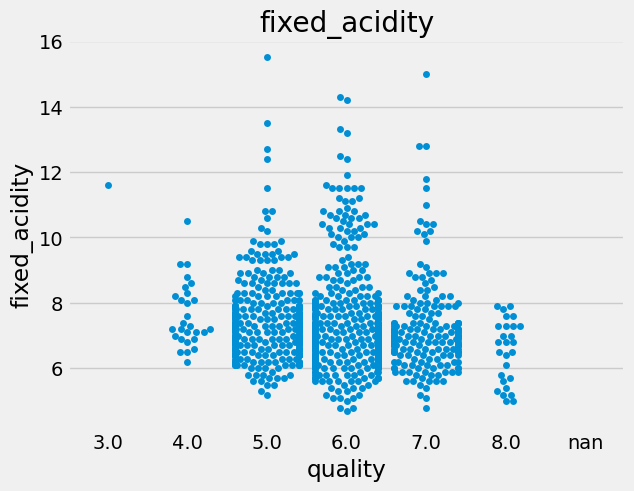

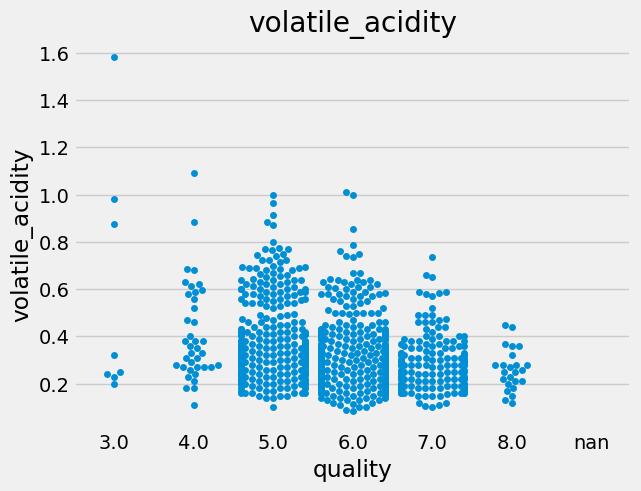

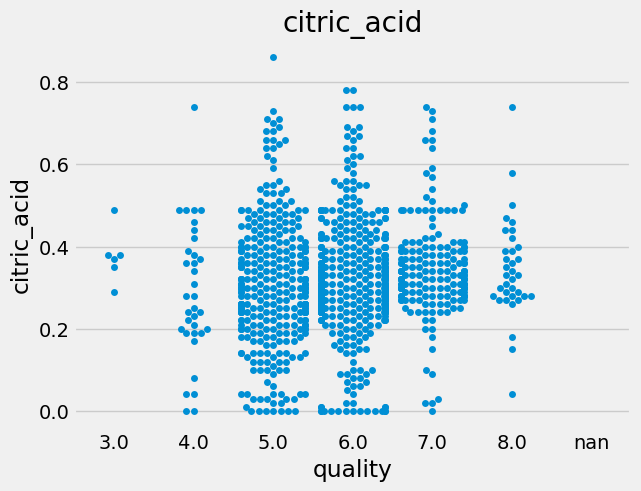

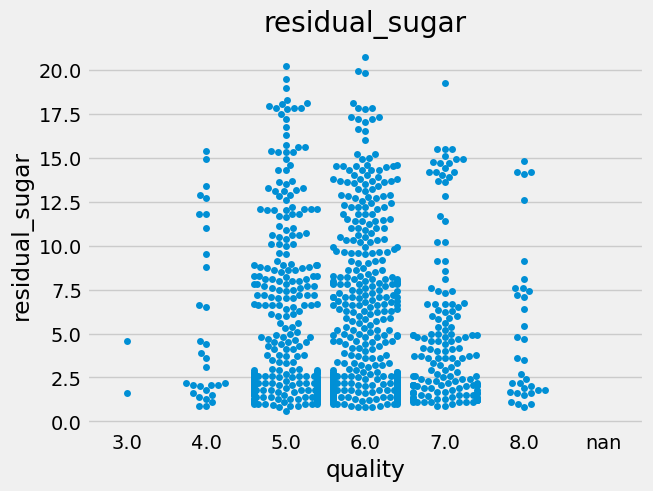

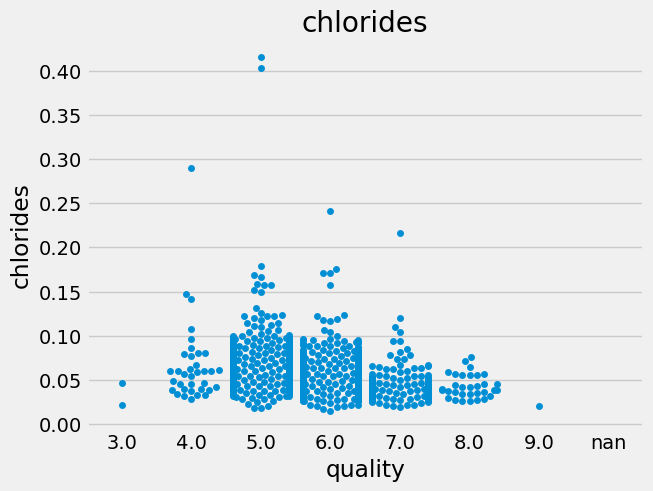

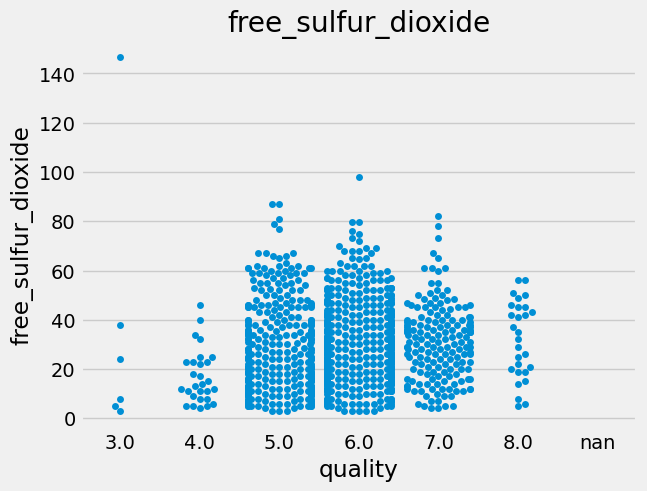

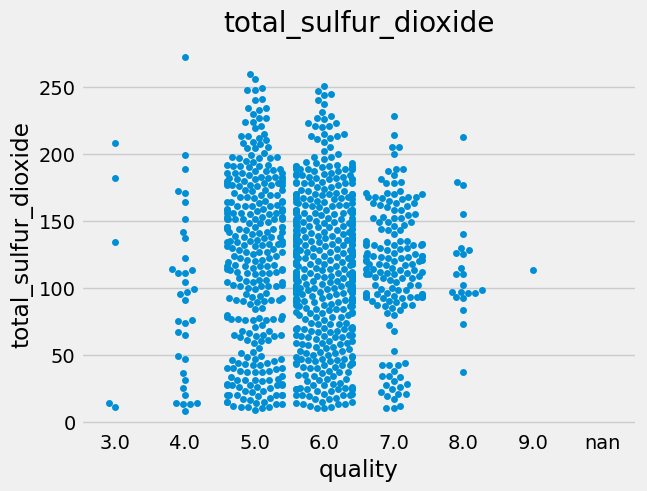

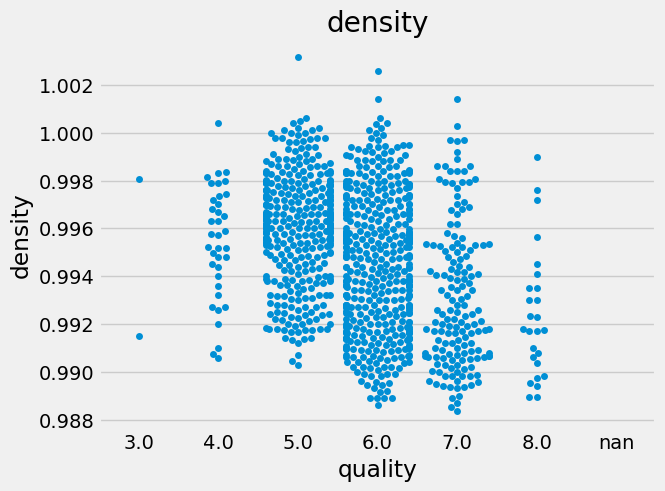

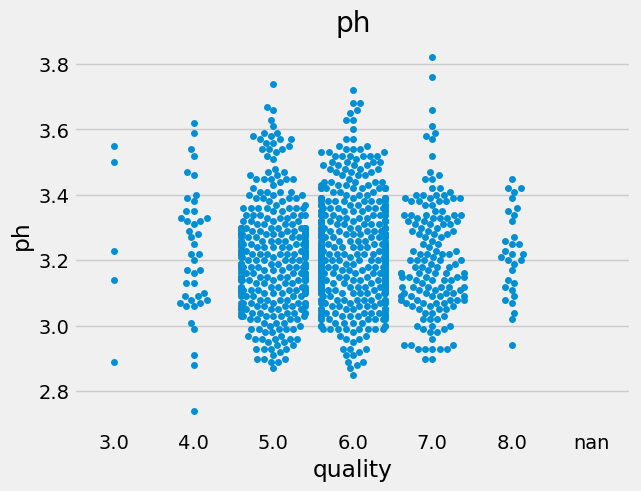

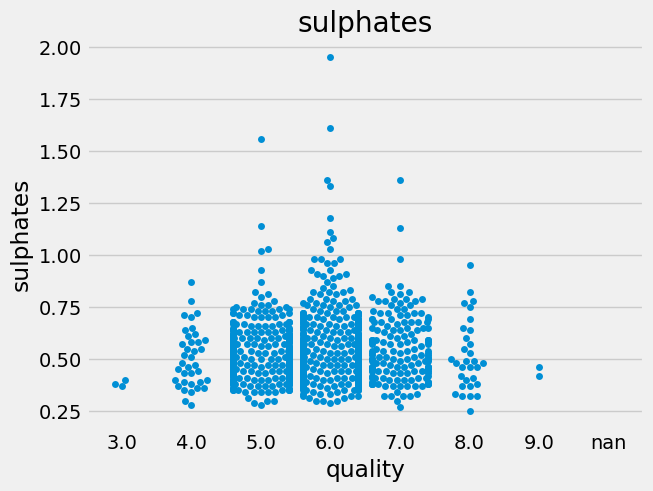

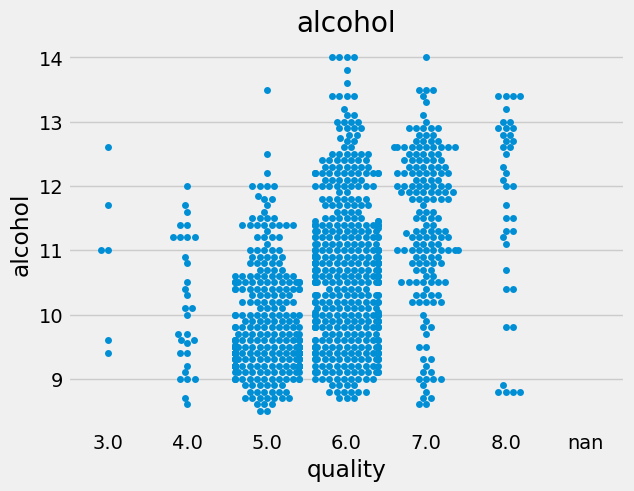

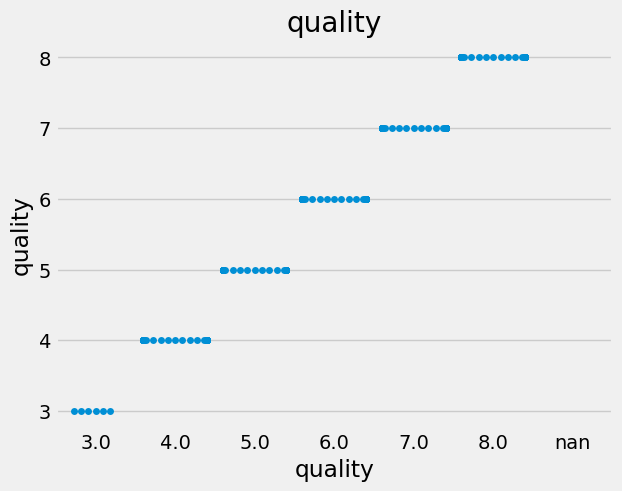

In [420]:
for col in train[num_cols]:
   sns.swarmplot(data=train.sample(1000), y=df[col], x='quality')
   t = col.lower()
   plt.title(t)
   plt.show()

>

> ### Takeaways:
>
> #### Relationships to target:
> - fixed_acidity: looks to have a negative correlation with quality
> - volatile_acidity: looks to have a strong negative correlation with quality
> - citric_acid: doesn't seem to have a linear correlation, there may be a signal revealed after clustering
> - chlorides: possibly a negative corelation with quality
> - free_sulfur_dioxide: relationship unclear
> - total_sulfur_dioxide: possible positive correlation
> - density: Pretty clear negative correlation
> - ph: Not a clear relationship
> - sulphates: Not a clear relationship
> - alcohol: Positive linear correlation
>
> Best features:
> * fixed_acidity: negative
> * volatile_acidity: strong negative
> * density: negative
> * alcohol: positive
>
> Not sure, lets do hypothesis testing:
> * chlorides
> * total_sulfur_dioxide
>
> Signal Unclear, let's cluster these:
> * citric_acid
> * ph
> * sulphates

## Multivariate Analysis

<Axes: xlabel='sulphates', ylabel='citric_acid'>

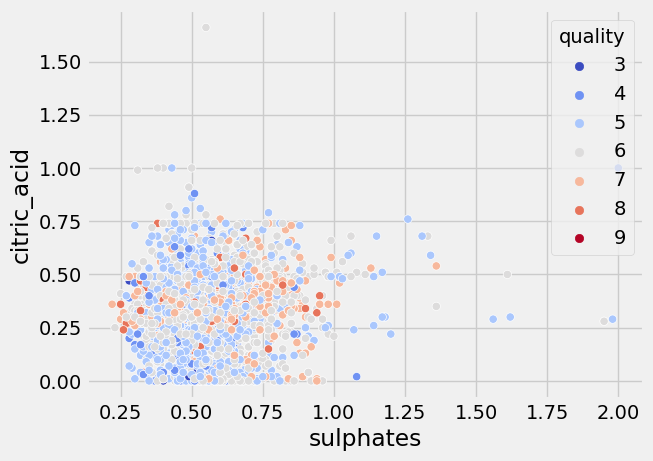

In [421]:
sns.scatterplot(data=train, x='sulphates', y='citric_acid', hue='quality', palette='coolwarm')

> citric_acid: Looks like there is something happening below about 0.25 and above about 0.5. Good candidate for clustering

<Axes: xlabel='sulphates', ylabel='total_sulfur_dioxide'>

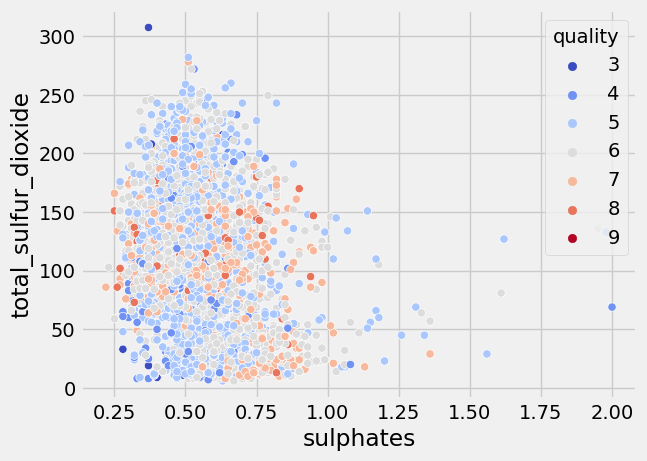

In [422]:
sns.scatterplot(data=train, x='sulphates', y='total_sulfur_dioxide', hue='quality', palette='coolwarm')

> 

> total_sulfur_dioxide: Looks like there is something happening below about 75 and above about 150. Good candidate for clustering.

<Axes: xlabel='sulphates', ylabel='volatile_acidity'>

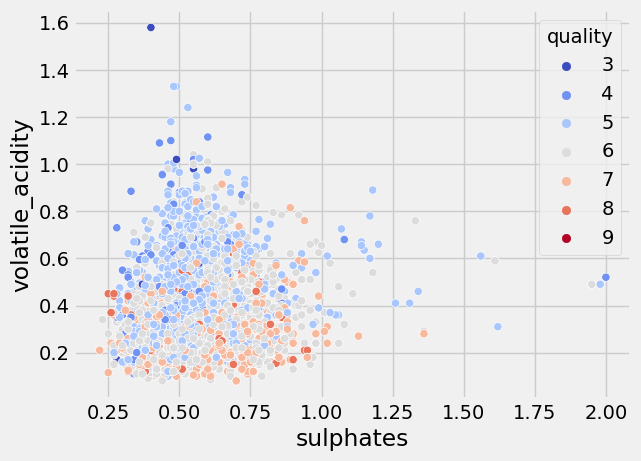

In [423]:
sns.scatterplot(data=train, x='sulphates', y='volatile_acidity', hue='quality', palette='coolwarm')

> sulphates: Maybe some signal below 0.50?

<Axes: xlabel='sulphates', ylabel='total_sulfur_dioxide'>

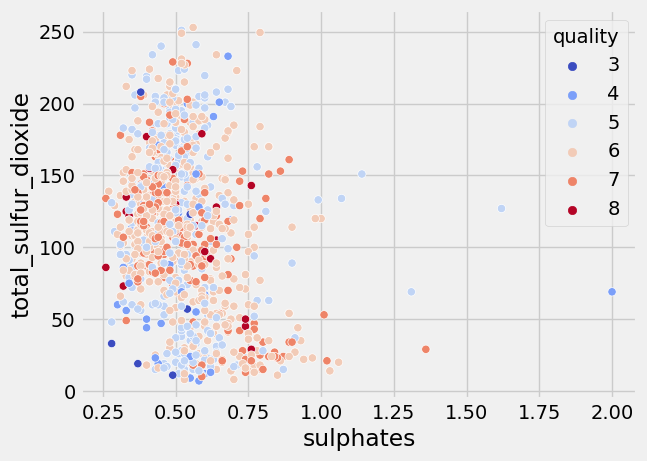

In [424]:
sns.scatterplot(data=train.sample(1000), x='sulphates', y='total_sulfur_dioxide', hue='quality', palette='coolwarm')

### Q1. Is there a relationship between fixed_acidity and quality?
<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

Assumptions:
Normality: both quality and fixed_acidity have relatively normal distribution.


**I will now use a Spearman correlation to check for a monotonic relationship betwen fixed_acidity and quality.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: There is no ordinal correlation between fixed_acidity and quality.**<br>
**Ha: There is an ordinal correlation between fixed_acidity and quality.**
</div>

In [425]:
# set alpha
alpha = 0.05

r, p = stats.spearmanr(train.fixed_acidity, train.quality)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between fixed_acidity and quality.')
    print(r, p)
else:
    print('We fail to reject the null hypothesis')
    print(r, p)


We can reject our null hypothesis and suggest that there is a relationship between fixed_acidity and quality.
-0.10158339416874636 5.217750741281213e-11


### Q2. Is there a relationship between chlorides and quality?

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

Assumptions:
Normality: both quality and chlorides have relatively normal distribution.


**I will now use a Spearman correlation to check for a monotonic relationship betwen chlorides and quality.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: There is no ordinal correlation between chlorides and quality.**<br>
**Ha: There is an ordinal correlation between chlorides and quality.**
</div>

In [426]:
r, p = stats.spearmanr(train.chlorides, train.quality)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between chlorides and quality.')
    print(r, p)
else:
    print('We fail to reject the null hypothesis')
    print(r, p)

We can reject our null hypothesis and suggest that there is a relationship between chlorides and quality.
-0.30451919102860586 6.36435669486711e-90


### Q3. Is there a relationship between total_sulfur_dioxide and quality?

<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">

Assumptions:
Normality: both quality and total_sulfur_dioxide have relatively normal distribution.


**I will now use a Spearman correlation to check for a monotonic relationship between total_sulfur_dioxide and quality.**

* I will use a confidence interval of 95% 
* The resulting alpha is .05<br>

**H0: There is no ordinal correlation between total_sulfur_dioxide and quality.**<br>
**Ha: There is an ordinal correlation between total_sulfur_dioxide and quality.**
</div>

In [427]:
r, p = stats.spearmanr(train.total_sulfur_dioxide, train.quality)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between total_sulfur_dioxide and quality.')
    print(r, p)
else:
    print('We fail to reject the null hypothesis')
    print(r, p)

We can reject our null hypothesis and suggest that there is a relationship between total_sulfur_dioxide and quality.
-0.03761888506073406 0.015283136547943535


## Clustering
> * citric_acid, total_sulfur_dioxide, sulphates

In [428]:
cluster_features_1 = train_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled']]
cluster_features_1_val = validate_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled']]
cluster_features_1_test = test_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled']]


cluster_features_2 = train_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled']]
cluster_features_2_val = validate_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled']]
cluster_features_2_test = test_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled']]


cluster_features_3 = train_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled', 'ph_scaled']]
cluster_features_3_val = validate_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled', 'ph_scaled']]
cluster_features_3_test = test_scaled[['citric_acid_scaled', 'sulphates_scaled', 'total_sulfur_dioxide_scaled', 'chlorides_scaled', 'ph_scaled']]


cluster_features_4 = train_scaled.drop(columns=['quality'])
cluster_features_4_val = validate_scaled.drop(columns=['quality'])
cluster_features_4_test = test_scaled.drop(columns=['quality'])

### KMeans

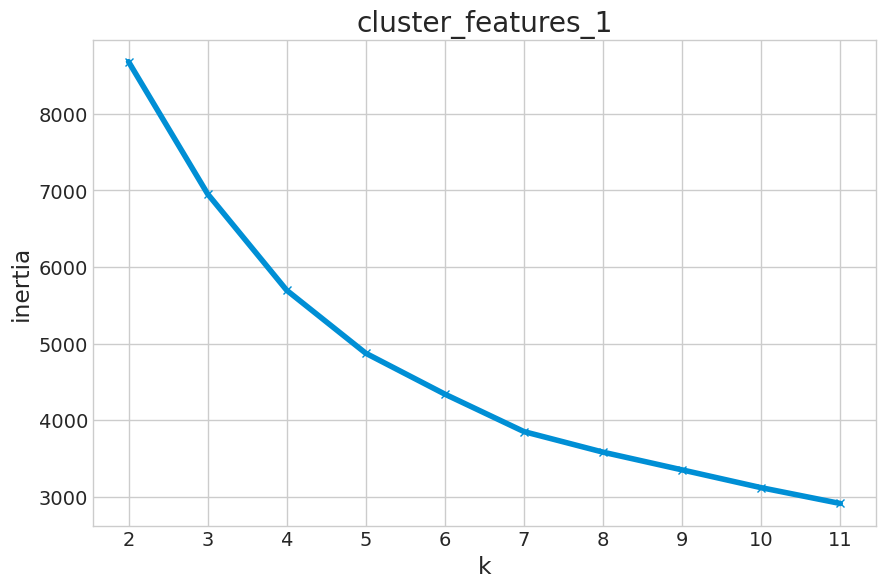

In [429]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_1).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_1')
    plt.ylabel('inertia')

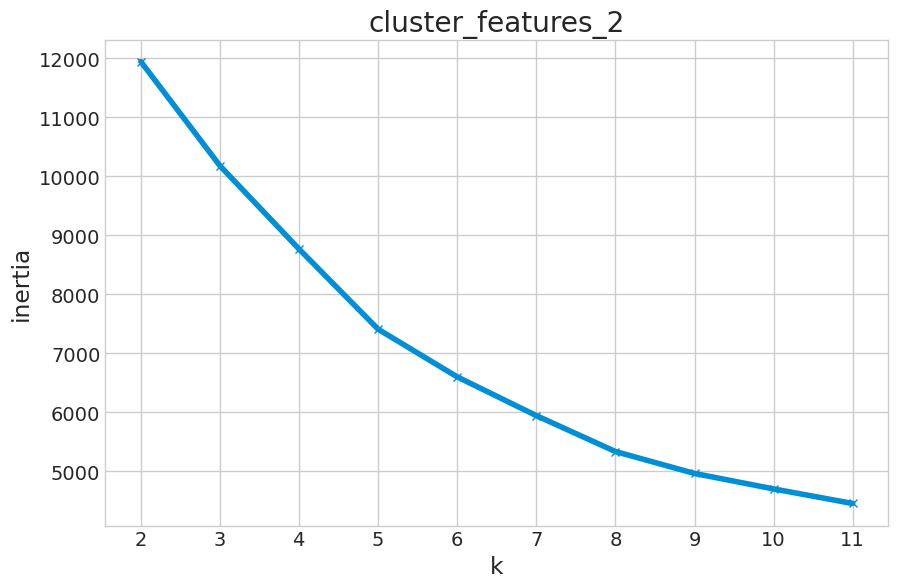

In [430]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_2')
    plt.ylabel('inertia')

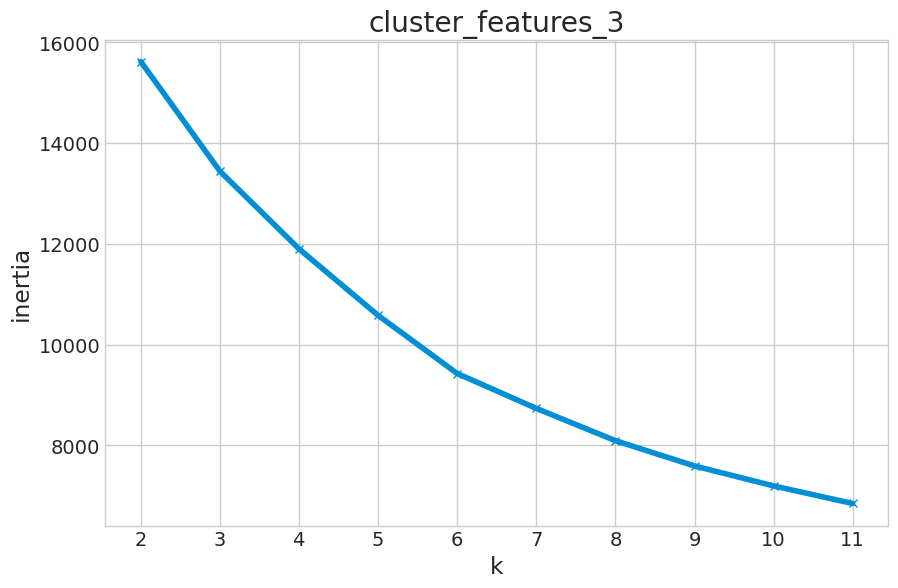

In [431]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_3')
    plt.ylabel('inertia')

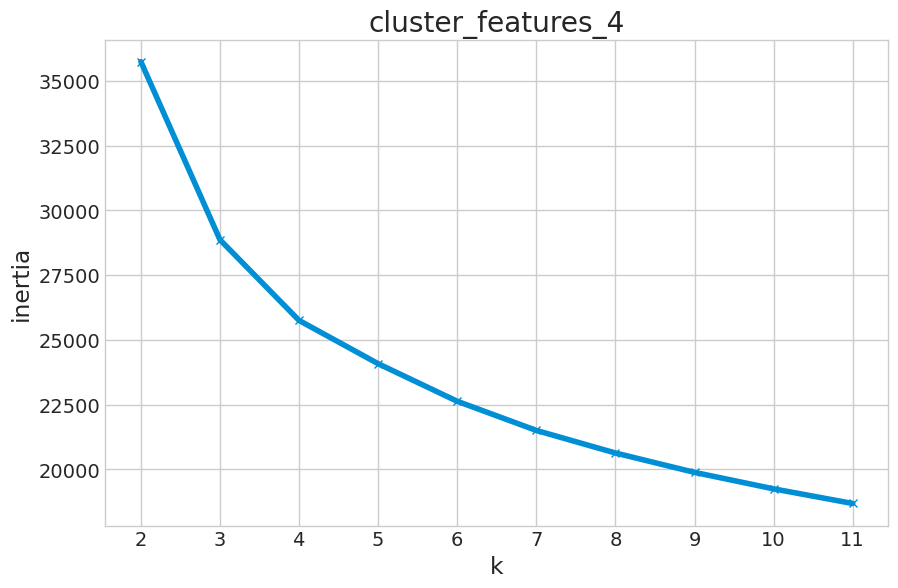

In [432]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    pd.Series({k: KMeans(k).fit(cluster_features_4).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.title('cluster_features_4')
    plt.ylabel('inertia')

> cluster_features_1: k=4, 3 5\
> cluster_features_2: k=5, 3 6\
> cluster_features_3: k=6, 4 5\
> cluster_features_4: k=3, 3

In [433]:
kmeans_1 = KMeans(n_clusters=4)
kmeans_2 = KMeans(n_clusters=5)
kmeans_3 = KMeans(n_clusters=6)
kmeans_4 = KMeans(n_clusters=3)

kmeans_1.fit(cluster_features_1)
kmeans_2.fit(cluster_features_2)
kmeans_3.fit(cluster_features_3)
kmeans_4.fit(cluster_features_4)

# Predict on train
clusters_1_train = kmeans_1.predict(cluster_features_1)
clusters_2_train = kmeans_2.predict(cluster_features_2)
clusters_3_train = kmeans_3.predict(cluster_features_3)
clusters_4_train = kmeans_4.predict(cluster_features_4)

# Predict on Val
clusters_1_val = kmeans_1.predict(cluster_features_1_val)
clusters_2_val = kmeans_2.predict(cluster_features_2_val)
clusters_3_val = kmeans_3.predict(cluster_features_3_val)
clusters_4_val = kmeans_4.predict(cluster_features_4_val)

# Add predictions to dataframes
train_scaled['clusters_1'] = clusters_1_train
train_scaled['clusters_2'] = clusters_2_train
train_scaled['clusters_3'] = clusters_3_train
train_scaled['clusters_4'] = clusters_4_train

validate_scaled['clusters_1'] = clusters_1_val
validate_scaled['clusters_2'] = clusters_2_val
validate_scaled['clusters_3'] = clusters_3_val
validate_scaled['clusters_4'] = clusters_4_val


In [434]:
train_scaled.columns

Index(['quality', 'is_red', 'fixed_acidity_scaled', 'volatile_acidity_scaled',
       'citric_acid_scaled', 'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled',
       'clusters_1', 'clusters_2', 'clusters_3', 'clusters_4'],
      dtype='object')

Text(0.5, 1.0, 'Cluster Model 1')

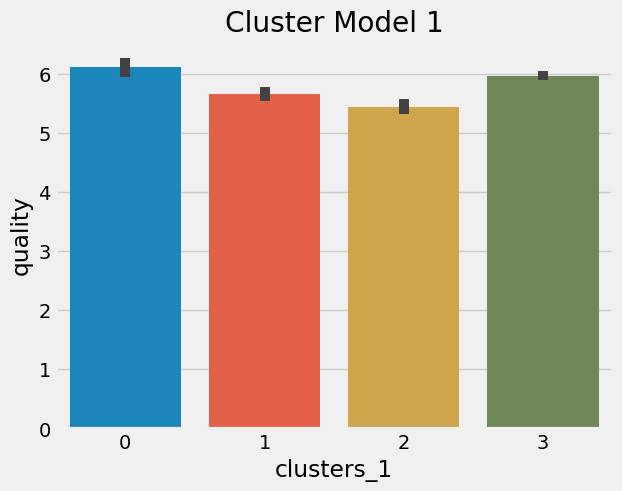

In [435]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_1')
plt.title('Cluster Model 1')

Text(0.5, 1.0, 'Cluster Model 2')

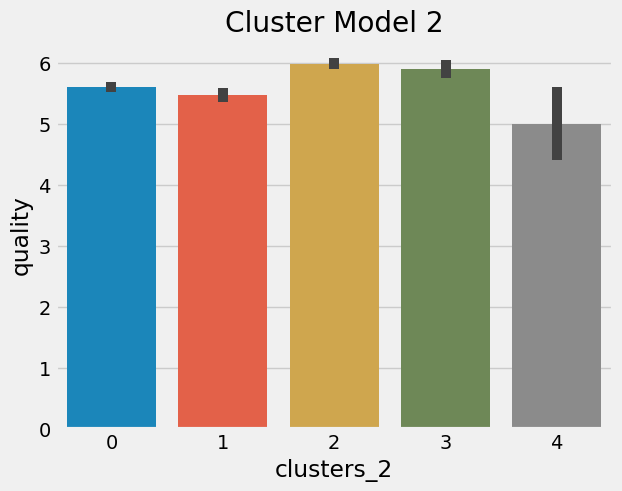

In [436]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_2')
plt.title('Cluster Model 2')

Text(0.5, 1.0, 'Cluster Model 3')

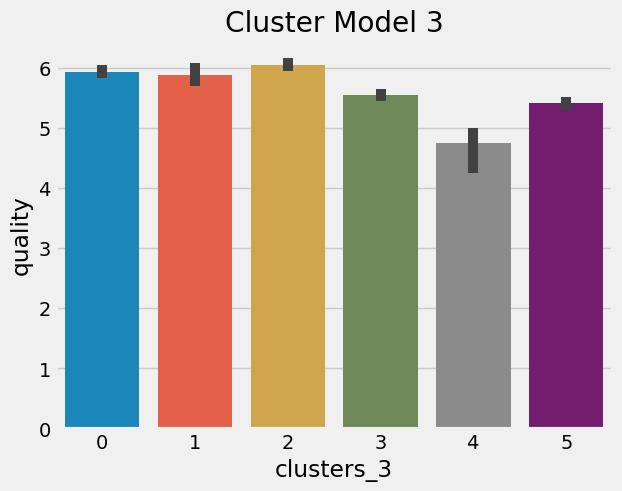

In [437]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_3')
plt.title('Cluster Model 3')

Text(0.5, 1.0, 'Cluster Model 4')

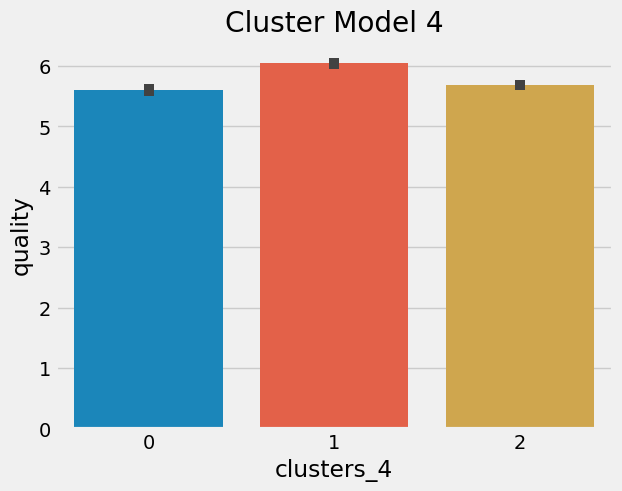

In [438]:
sns.barplot(data=train_scaled.sample(1000), y='quality', x='clusters_4')
plt.title('Cluster Model 4')

### Q4. cluster 1, 2, 3 (Anova?)

<hr style="border:2px solid black">

# **Modeling**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver

In [477]:
baseline = (train.quality == 6).sum()/ len(train)
baseline

0.43661294202549916

In [478]:
# features
best_independent = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled']
features_1 = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled', 'clusters_1', 'is_red']
features_2 = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled', 'clusters_2', 'is_red']
features_3 = ['fixed_acidity_scaled', 'volatile_acidity_scaled','density_scaled', 'alcohol_scaled', 'clusters_3','is_red']

In [479]:
x_train_scaled.columns

Index(['is_red', 'fixed_acidity_scaled', 'volatile_acidity_scaled',
       'citric_acid_scaled', 'residual_sugar_scaled', 'chlorides_scaled',
       'free_sulfur_dioxide_scaled', 'total_sulfur_dioxide_scaled',
       'density_scaled', 'ph_scaled', 'sulphates_scaled', 'alcohol_scaled',
       'clusters_1', 'clusters_2', 'clusters_3', 'clusters_4'],
      dtype='object')

In [480]:
# split into x and y for each distinct feature space

x_train_scaled = train_scaled.drop(columns=['quality'])
x_train_1 = x_train_scaled[features_1]
x_train_2 = x_train_scaled[features_2]
x_train_3 = x_train_scaled[features_3]
x_train_4 = 
y_train = train.quality.to_frame()

x_val_scaled = validate_scaled.drop(columns=['quality'])
x_validate_1 = x_val_scaled[features_1]
x_validate_2 = x_val_scaled[features_2]
x_validate_3 = x_val_scaled[features_3]
y_validate = validate.quality.to_frame()

# x_test_scaled = test_scaled.drop(columns=['quality'])
# x_test_1 = x_test_scaled[features_1]
# y_test = test.quality.to_frame()

## Decision Tree

In [481]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(x_train_1, y_train)
    
    # evaluate on train
    train_acc = clf.score(x_train_1, y_train)
    
    #evaluate on validate
    val_acc = clf.score(x_validate_1, y_validate)
    
    scores_all.append([x,baseline, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head(20)

,max_depth,baseline,train_acc,val_acc
13,14,0.436613,0.838104,0.546154
4,5,0.436613,0.568679,0.546154
3,4,0.436613,0.557614,0.545192
6,7,0.436613,0.605725,0.545192
8,9,0.436613,0.659370,0.545192
15,16,0.436613,0.904498,0.544231
7,8,0.436613,0.629781,0.543269
12,13,0.436613,0.794323,0.540385
18,19,0.436613,0.964638,0.538462
10,11,0.436613,0.717585,0.538462


In [482]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(x_train_2, y_train)
    
    # evaluate on train
    train_acc = clf.score(x_train_2, y_train)
    
    #evaluate on validate
    val_acc = clf.score(x_validate_2, y_validate)
    
    scores_all.append([x,baseline, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head()

,max_depth,baseline,train_acc,val_acc
18,19,0.436613,0.952610,0.567308
13,14,0.436613,0.819341,0.563462
16,17,0.436613,0.913399,0.562500
11,12,0.436613,0.747414,0.557692
12,13,0.436613,0.782295,0.556731


In [483]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x, random_state=666)
    clf.fit(x_train_3, y_train)
    
    # evaluate on train
    train_acc = clf.score(x_train_3, y_train)
    
    #evaluate on validate
    val_acc = clf.score(x_validate_3, y_validate)
    
    scores_all.append([x,baseline, train_acc, val_acc])
    
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df = pd.DataFrame(scores_all, columns=['max_depth','baseline','train_acc','val_acc'])
scores_df.sort_values(by=['val_acc'], ascending=False).head(10)

,max_depth,baseline,train_acc,val_acc
18,19,0.436613,0.976185,0.550000
4,5,0.436613,0.568679,0.546154
7,8,0.436613,0.631465,0.546154
3,4,0.436613,0.557614,0.545192
17,18,0.436613,0.962232,0.544231
12,13,0.436613,0.794323,0.543269
13,14,0.436613,0.838345,0.542308
8,9,0.436613,0.659370,0.541346
6,7,0.436613,0.607169,0.539423
16,17,0.436613,0.942747,0.538462


> Best DT Model: Feature set 2 & max_depth= 5 \
> train: 0.5687
> validate: 0.547

## Random Forest

In [484]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)


In [485]:
rf.fit(x_train_1, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [486]:
print(rf.feature_importances_)

[0.02287036 0.21649428 0.23988742 0.45392865 0.03888977 0.02792951]


In [487]:
y_pred = rf.predict(x_train_1)

In [488]:
y_pred_proba = rf.predict_proba(x_train_1)

In [489]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(x_train_1, y_train)))


Accuracy of random forest classifier on training set: 0.54


In [490]:
print(confusion_matrix(y_train, y_pred))


[[   0    0    7   12    0    0    0]
 [   0    0   68   71    0    0    0]
 [   0    0  856  512    0    0    0]
 [   0    0  440 1375    0    0    0]
 [   0    0   39  650    1    0    0]
 [   0    0    1  122    0    0    0]
 [   0    0    0    3    0    0    0]]


In [491]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00       139
           5       0.61      0.63      0.62      1368
           6       0.50      0.76      0.60      1815
           7       1.00      0.00      0.00       690
           8       0.00      0.00      0.00       123
           9       0.00      0.00      0.00         3

    accuracy                           0.54      4157
   macro avg       0.30      0.20      0.17      4157
weighted avg       0.58      0.54      0.47      4157



In [492]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(x_validate_1, y_validate)))


Accuracy of random forest classifier on test set: 0.54


## KNN

In [493]:
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(x_train_1, y_train)

    # print results
    print(f"{n} = n_neighbors on train is {knn.score(x_train_1, y_train): .2%}")
    print(f"{n} = n_neighbors on validate is        {knn.score(x_validate_1, y_validate): .2%}")

1 = n_neighbors on train is  99.88%
1 = n_neighbors on validate is         56.44%
2 = n_neighbors on train is  79.38%
2 = n_neighbors on validate is         49.81%
3 = n_neighbors on train is  74.24%
3 = n_neighbors on validate is         50.29%
4 = n_neighbors on train is  69.91%
4 = n_neighbors on validate is         51.06%
5 = n_neighbors on train is  66.88%
5 = n_neighbors on validate is         53.46%
6 = n_neighbors on train is  65.14%
6 = n_neighbors on validate is         54.42%
7 = n_neighbors on train is  63.82%
7 = n_neighbors on validate is         54.81%


8 = n_neighbors on train is  62.50%
8 = n_neighbors on validate is         54.13%
9 = n_neighbors on train is  62.45%
9 = n_neighbors on validate is         54.52%
10 = n_neighbors on train is  62.04%
10 = n_neighbors on validate is         54.90%
11 = n_neighbors on train is  62.04%
11 = n_neighbors on validate is         54.33%
12 = n_neighbors on train is  61.01%
12 = n_neighbors on validate is         53.56%
13 = n_neighbors on train is  60.57%
13 = n_neighbors on validate is         53.85%
14 = n_neighbors on train is  60.14%
14 = n_neighbors on validate is         53.46%
15 = n_neighbors on train is  60.09%
15 = n_neighbors on validate is         53.65%
16 = n_neighbors on train is  59.73%
16 = n_neighbors on validate is         53.17%
17 = n_neighbors on train is  59.15%
17 = n_neighbors on validate is         53.85%
18 = n_neighbors on train is  59.03%
18 = n_neighbors on validate is         54.42%
19 = n_neighbors on train is  58.72%
19 = n_neighbors on validate is         54.

In [494]:
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(x_train_2, y_train)

    # print results
    print(f"{n} = n_neighbors on train is {knn.score(x_train_2, y_train): .2%}")
    print(f"{n} = n_neighbors on validate is            {knn.score(x_validate_2, y_validate): .2%}")

1 = n_neighbors on train is  99.90%
1 = n_neighbors on validate is             57.79%
2 = n_neighbors on train is  79.07%
2 = n_neighbors on validate is             50.29%
3 = n_neighbors on train is  74.33%
3 = n_neighbors on validate is             50.96%
4 = n_neighbors on train is  69.43%
4 = n_neighbors on validate is             52.40%
5 = n_neighbors on train is  66.18%
5 = n_neighbors on validate is             54.52%
6 = n_neighbors on train is  64.52%
6 = n_neighbors on validate is             54.42%
7 = n_neighbors on train is  63.53%
7 = n_neighbors on validate is             55.10%
8 = n_neighbors on train is  61.97%
8 = n_neighbors on validate is             54.62%
9 = n_neighbors on train is  61.61%
9 = n_neighbors on validate is             54.23%
10 = n_neighbors on train is  60.96%
10 = n_neighbors on validate is             53.94%
11 = n_neighbors on train is  60.91%
11 = n_neighbors on validate is             53.37%
12 = n_neighbors on train is  60.62%
12 = n_neighb

In [495]:
for n in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(x_train_3, y_train)

    # print results
    print(f"{n} = n_neighbors on train is {knn.score(x_train_3, y_train): .2%}")
    print(f"{n} = n_neighbors on validate is        {knn.score(x_validate_3, y_validate): .2%}")

1 = n_neighbors on train is  99.90%
1 = n_neighbors on validate is         55.48%
2 = n_neighbors on train is  79.84%
2 = n_neighbors on validate is         50.19%
3 = n_neighbors on train is  75.15%
3 = n_neighbors on validate is         48.75%
4 = n_neighbors on train is  70.46%
4 = n_neighbors on validate is         51.63%
5 = n_neighbors on train is  67.28%
5 = n_neighbors on validate is         52.88%
6 = n_neighbors on train is  65.05%
6 = n_neighbors on validate is         52.60%
7 = n_neighbors on train is  64.04%
7 = n_neighbors on validate is         53.27%
8 = n_neighbors on train is  62.47%
8 = n_neighbors on validate is         55.19%
9 = n_neighbors on train is  62.57%
9 = n_neighbors on validate is         53.56%
10 = n_neighbors on train is  61.53%
10 = n_neighbors on validate is         53.37%
11 = n_neighbors on train is  61.51%
11 = n_neighbors on validate is         55.19%
12 = n_neighbors on train is  60.76%
12 = n_neighbors on validate is         54.71%
13 = n_nei

> Best Overall Models: 
>
> <u> KNN </u> \
> Keeping all outliers: \
> Feature set 3; n_neighbors is 20 \
> Train: 58.38% \
> Validate: 56.25%
>
> <u> KNN </u> \
> Dropping outliers beyond 3 * iqr: \
> Feature set 3; n_neibhors is 27 \
> Train: 58.09% \
> Validate: 56.31% 

<hr style="border:2px solid black">

# **Conclusions**
